## Import stuff

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from mysticetus import Models
from mysticetus import Objective
from mysticetus import InspectObjective
from mysticetus import aux
from mysticetus import model_driven_reco

In [2]:
class SavingObject(object):
    pass

In [3]:
interims = {}
savings = SavingObject()

pl = Objective.Pipeline([\
    Models.DistModelGrating2D(
        save=InspectObjective.GetSetChain([\
            InspectObjective.GetSet(
                InspectObjective.DeepCopyKeyGetter(interims, 'dist'),
                InspectObjective.AttributeSetter(savings, 'dist')
            )
        ])
    ),
    aux.MeasModelFarField(
        save=InspectObjective.GetSetChain([\
            InspectObjective.GetSet(
                InspectObjective.DeepCopyKeyGetter(interims, 'far_field'),
                InspectObjective.AttributeSetter(savings, 'untouched_far_field')
            )
        ])
    ),
    aux.RotateFF(),
    aux.DisplaceMeas(),
    aux.CropFarfield(),
    aux.DrawExperimentalPhotonCount(),
    aux.Farfield2Intensity(),
    aux.Models.ConvolveIntensityWithConstantPSF(),
    aux.CutoffIntensity(
        save=InspectObjective.GetSetChain([\
            InspectObjective.GetSet(
                InspectObjective.DeepCopyKeyGetter(interims, 'meas'),
                InspectObjective.AttributeSetter(savings, 'endproduct')
            )
        ])
    )
])

In [4]:
def create_domain(ny, nx):
    xres    = 4*nx
    yres    = 4*ny
    x       = np.linspace(0, xres, xres, endpoint=False)
    y       = np.linspace(0, xres, yres, endpoint=False)
    xx, yy  = np.meshgrid(x, y)
    return {'x':x, 'y':y, 'xx':xx, 'yy':yy}

In [5]:
nx, ny = 256, 256
domain = create_domain(ny, nx)
cutoff = np.exp(15.)

consts = {\
    'domain':               domain,
    'crop_slice':           (slice(ny, 3*ny), slice(nx, 3*nx)),
    'photon_statistics':    lambda x : x,
    'psf':                  model_driven_reco.create_psf(domain['xx'], domain['yy'], 2.7),
    'cutoff':               cutoff}

params = {\
    'sigma': 0.,
    'pitch': 3.1,
    'fsize': 1.52,
    'ff_angle': 0.15,
    'disp': (73, -150)}

In [6]:
pl(params, interims, consts)

/home/mz6084/.conda/envs/my_root/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/mz6084/.conda/envs/my_root/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


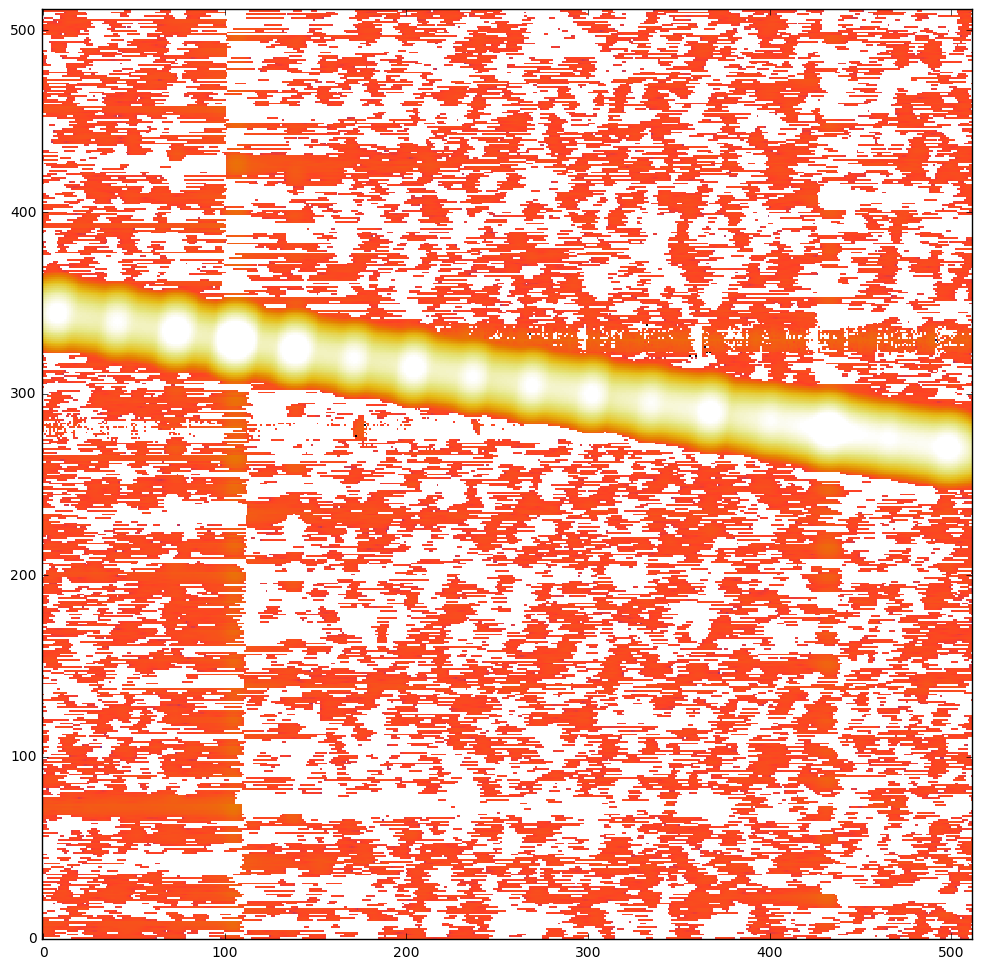

In [7]:
dat = np.log(savings.endproduct)
plt.figure(figsize=(20,12))
plt.imshow(dat, **aux.iss)